In [1]:
import glob
import h5py
import numpy as np
import os
import pylab
import scipy.linalg
import scipy as sp
import sys

from numpy import array, concatenate, zeros
from numpy.random import randn
from scipy.optimize import minimize

from functools import reduce

from openfermion.config import *
from openfermionprojectq import *

from openfermion.hamiltonians import MolecularData
from openfermion.transforms import get_fermion_operator, jordan_wigner, bravyi_kitaev, get_sparse_operator
from openfermion.utils import uccsd_singlet_paramsize
from openfermion.ops import FermionOperator

from openfermionpsi4 import run_psi4

from projectq.ops import X, All, Measure
from projectq.backends import CommandPrinter, CircuitDrawer
from projectq.ops import (BasicGate,
                          H,
                          X,
                          CNOT,
                          Measure,
                          Z,
                          Swap,
                          C,
                          Rx,
                          Rz)
from projectq.backends._circuits import to_latex
from projectq.backends import _printer

%matplotlib inline

hartree_to_kcal = 627.50947415

In [2]:
def canonical_eigh(M, S):
    """Return the eigenvectors and eigenvalues in the original basis with potentially singular S"""
    #Solve for spectrum with canonical orthogonalization
    overlapCutoff = 1.0e-8
    [evals, evecs] = sp.linalg.eigh(S)

    #Determine rank
    RankOverlap = np.sum(evals > overlapCutoff)
    nullity = len(evals) - RankOverlap
    #Cutoff
    evals = evals[nullity:]
    evecs = evecs[:, nullity:]

    #Make transformation matrix
    U = np.dot(evecs, np.diag(evals**(-0.5)))

    #Transform the Hamiltonian and find the new eigenvectors
    M_prime = np.dot(np.conj(U).T, np.dot(M, U))
    S_prime = np.dot(np.conj(U).T, np.dot(S, U))

    e_vals, e_vecs = sp.linalg.eigh(M_prime, S_prime)
    #Transform eigenvectors back to original basis
    e_vecs = np.dot(U, e_vecs)
    
    return e_vals, e_vecs, U

def FindSymmTransform(M, S, val):
    """Find a transform to project onto the eigenspace corresponding to eigenvalue val of operator 
    representation M with overlap S"""
    e_vals, e_vecs, U = canonical_eigh(M, S)
    indices = np.where(np.abs(e_vals-val) < 0.1)[0]
    U = e_vecs[:, indices]
    return U

In [3]:
# Load files
molecule_filenames = sorted(glob.glob('data/*.hdf5'))
test_molecule = MolecularData(filename=molecule_filenames[0])
print("Number of spatial basis functions: {}".format(test_molecule.n_orbitals))
print("Number of electrons: {}".format(test_molecule.n_electrons))
test_molecule = None

Number of spatial basis functions: 52
Number of electrons: 16


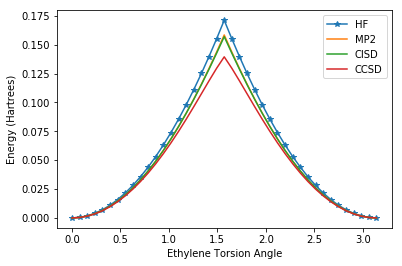

In [4]:
# Plot CCSD curve for angle
angles = []
hf_energies = []
mp2_energies = []
cisd_energies = []
ccsd_energies = []

for filename in molecule_filenames:
    angle = float(filename.split('_')[-1].rstrip('.hdf5'))
    molecule = MolecularData(filename=filename)
    
    angles.append(angle)
    hf_energies.append(molecule.hf_energy)
    mp2_energies.append(molecule.mp2_energy)
    cisd_energies.append(molecule.cisd_energy)
    ccsd_energies.append(molecule.ccsd_energy)

pylab.xlabel("Ethylene Torsion Angle")
pylab.ylabel("Energy (Hartrees)")
pylab.plot(angles, np.array(hf_energies) - hf_energies[0], '*-', label="HF")
pylab.plot(angles, np.array(mp2_energies) - mp2_energies[0], label="MP2")
pylab.plot(angles, np.array(cisd_energies) - cisd_energies[0], label="CISD")
pylab.plot(angles, np.array(ccsd_energies) - ccsd_energies[0], label="CCSD")
pylab.legend()

Qubit Hamiltonian Matrix
[[-76.86638025+0.j   0.00000000+0.j]
 [  0.00000000+0.j -78.04891685+0.j]]

Energy: -78.04891684583123	 Number: (2+0j)	 Sz:0j	 S^2:0j
Qubit Hamiltonian Matrix
[[-76.86759778+0.j   0.00000000+0.j]
 [  0.00000000+0.j -78.04847427+0.j]]

Energy: -78.04847426828763	 Number: (2+0j)	 Sz:0j	 S^2:0j
Qubit Hamiltonian Matrix
[[-76.87112449+0.j   0.00000000+0.j]
 [  0.00000000+0.j -78.04714686+0.j]]

Energy: -78.04714686089714	 Number: (2+0j)	 Sz:0j	 S^2:0j
Qubit Hamiltonian Matrix
[[-76.87662076+0.j   0.00000000+0.j]
 [  0.00000000+0.j -78.04493561+0.j]]

Energy: -78.04493561435751	 Number: (2+0j)	 Sz:0j	 S^2:0j
Qubit Hamiltonian Matrix
[[-76.88362529+0.j   0.00000000+0.j]
 [  0.00000000+0.j -78.04184223+0.j]]

Energy: -78.04184222696486	 Number: (2+0j)	 Sz:0j	 S^2:0j
Qubit Hamiltonian Matrix
[[-76.89165449+0.j   0.00000000+0.j]
 [  0.00000000+0.j -78.03786917+0.j]]

Energy: -78.03786916696703	 Number: (2+0j)	 Sz:0j	 S^2:0j
Qubit Hamiltonian Matrix
[[-76.90027299+0.j   


Energy: -78.0594207637029	 Number: (1.9999999999999996+0j)	 Sz:0j	 S^2:0j
Qubit Hamiltonian Matrix
[[-76.88362529+0.j   0.00000000+0.j   0.00000000+0.j   0.00000000+0.j
    0.00000000+0.j]
 [  0.00000000+0.j -77.54477256+0.j   0.00000000+0.j   0.08547376+0.j
    0.00000000+0.j]
 [  0.00000000+0.j   0.00000000+0.j -77.72659535+0.j   0.00000000+0.j
    0.00000000+0.j]
 [  0.00000000+0.j   0.08547376+0.j   0.00000000+0.j -78.04184223+0.j
    0.00000000+0.j]
 [  0.00000000+0.j   0.00000000+0.j   0.00000000+0.j   0.00000000+0.j
  -77.42906485+0.j]]

Energy: -78.05612924707025	 Number: (1.9999999999999998+0j)	 Sz:0j	 S^2:0j
Qubit Hamiltonian Matrix
[[-76.89165449+0.j   0.00000000+0.j   0.00000000+0.j   0.00000000+0.j
    0.00000000+0.j]
 [  0.00000000+0.j -77.56044884+0.j   0.00000000+0.j   0.08329680+0.j
    0.00000000+0.j]
 [  0.00000000+0.j   0.00000000+0.j -77.73350753+0.j   0.00000000+0.j
    0.00000000+0.j]
 [  0.00000000+0.j   0.08329680+0.j   0.00000000+0.j -78.03786917+0.j
    0.00

    0.00000000e+00+0.j  -7.74496394e+01+0.j]]

Energy: -77.95338441210059	 Number: (2+0j)	 Sz:0j	 S^2:0j
Qubit Hamiltonian Matrix
[[ -7.69791969e+01+0.j   0.00000000e+00+0.j   0.00000000e+00+0.j
    0.00000000e+00+0.j   0.00000000e+00+0.j]
 [  0.00000000e+00+0.j  -7.78222475e+01+0.j   0.00000000e+00+0.j
    6.62173968e-02+0.j   0.00000000e+00+0.j]
 [  0.00000000e+00+0.j   0.00000000e+00+0.j  -7.78062656e+01+0.j
    0.00000000e+00+0.j   0.00000000e+00+0.j]
 [  0.00000000e+00+0.j   6.62173968e-02+0.j   0.00000000e+00+0.j
   -7.79092428e+01+0.j   0.00000000e+00+0.j]
 [  0.00000000e+00+0.j   0.00000000e+00+0.j   0.00000000e+00+0.j
    0.00000000e+00+0.j  -7.74488925e+01+0.j]]

Energy: -77.94497134845615	 Number: (2+0j)	 Sz:0j	 S^2:0j
Qubit Hamiltonian Matrix
[[ -7.69817178e+01+0.j   0.00000000e+00+0.j   0.00000000e+00+0.j
    0.00000000e+00+0.j   0.00000000e+00+0.j]
 [  0.00000000e+00+0.j  -7.78405100e+01+0.j   0.00000000e+00+0.j
    6.60802623e-02+0.j   0.00000000e+00+0.j]
 [  0.00000000e

    0.00000000e+00+0.j  -7.74427042e+01+0.j]]

Energy: -78.01979227303362	 Number: (2+0j)	 Sz:0j	 S^2:0j
Qubit Hamiltonian Matrix
[[ -7.69265243e+01+0.j   0.00000000e+00+0.j   0.00000000e+00+0.j
    0.00000000e+00+0.j   0.00000000e+00+0.j]
 [  0.00000000e+00+0.j  -7.76379027e+01+0.j   0.00000000e+00+0.j
    7.48695490e-02+0.j   0.00000000e+00+0.j]
 [  0.00000000e+00+0.j   0.00000000e+00+0.j  -7.77638671e+01+0.j
    0.00000000e+00+0.j   0.00000000e+00+0.j]
 [  0.00000000e+00+0.j   7.48695490e-02+0.j   0.00000000e+00+0.j
   -7.80132609e+01+0.j   0.00000000e+00+0.j]
 [  0.00000000e+00+0.j   0.00000000e+00+0.j   0.00000000e+00+0.j
    0.00000000e+00+0.j  -7.74404643e+01+0.j]]

Energy: -78.0276434147554	 Number: (2+0j)	 Sz:0j	 S^2:0j
Qubit Hamiltonian Matrix
[[ -7.69179425e+01+0.j   0.00000000e+00+0.j   0.00000000e+00+0.j
    0.00000000e+00+0.j   0.00000000e+00+0.j]
 [  0.00000000e+00+0.j  -7.76171833e+01+0.j   0.00000000e+00+0.j
    7.67774070e-02+0.j   0.00000000e+00+0.j]
 [  0.00000000e+

Qubit Hamiltonian Matrix
[[ -7.70197957e+01+0.j   6.66537792e-18+0.j  -3.58983091e-24+0.j ...,
   -5.15268601e-25+0.j   4.35860795e-03+0.j   2.39101678e-03+0.j]
 [  6.66537792e-18+0.j  -7.66873595e+01+0.j   2.46797183e-03+0.j ...,
    6.05550725e-06+0.j  -7.14131555e-15+0.j   2.91029656e-03+0.j]
 [ -3.58983091e-24+0.j   2.46797183e-03+0.j  -7.67974336e+01+0.j ...,
    4.05042739e-05+0.j   1.41950816e-19+0.j  -5.12486116e-03+0.j]
 ..., 
 [ -5.15268601e-25+0.j   6.05550725e-06+0.j   4.05042739e-05+0.j ...,
   -7.69814103e+01+0.j   5.59298635e-22+0.j   5.21451612e-04+0.j]
 [  4.35860795e-03+0.j  -7.14131555e-15+0.j   1.41950816e-19+0.j ...,
    5.59298635e-22+0.j  -7.71961426e+01+0.j   2.26277496e-15+0.j]
 [  2.39101678e-03+0.j   2.91029656e-03+0.j  -5.12486116e-03+0.j ...,
    5.21451612e-04+0.j   2.26277496e-15+0.j  -7.68963278e+01+0.j]]

Energy: -78.0601458918211	 Number: (3.9999999999999987+0j)	 Sz:(-6.298986696732369e-35+0j)	 S^2:(6.926542023291186e-34+0j)
Qubit Hamiltonian Matrix
[[

Qubit Hamiltonian Matrix
[[ -7.69513408e+01+0.j   6.67078883e-18+0.j   5.03830754e-23+0.j ...,
   -1.18834744e-24+0.j   2.32328952e-03+0.j   2.29864314e-03+0.j]
 [  6.67078883e-18+0.j  -7.67479886e+01+0.j   4.83579153e-03+0.j ...,
    1.39656220e-05+0.j  -7.14702033e-15+0.j   2.26923086e-03+0.j]
 [  5.03830754e-23+0.j   4.83579153e-03+0.j  -7.68137042e+01+0.j ...,
    3.73521977e-05+0.j   2.54219919e-19+0.j  -1.12258240e-02+0.j]
 ..., 
 [ -1.18834744e-24+0.j   1.39656220e-05+0.j   3.73521977e-05+0.j ...,
   -7.70431363e+01+0.j   1.28989249e-21+0.j   1.11558627e-03+0.j]
 [  2.32328952e-03+0.j  -7.14702033e-15+0.j   2.54219919e-19+0.j ...,
    1.28989249e-21+0.j  -7.72046216e+01+0.j   1.20628527e-15+0.j]
 [  2.29864314e-03+0.j   2.26923086e-03+0.j  -1.12258240e-02+0.j ...,
    1.11558627e-03+0.j   1.20628527e-15+0.j  -7.69066694e+01+0.j]]

Energy: -78.00572524844853	 Number: (4.000000000000001+0j)	 Sz:(-4.112676582721609e-34+0j)	 S^2:(4.484898203494595e-33+0j)
Qubit Hamiltonian Matrix
[[

Qubit Hamiltonian Matrix
[[ -7.68803324e+01+0.j   6.67596842e-18+0.j  -1.51902347e-23+0.j ...,
   -1.20959318e-24+0.j   1.68961723e-03+0.j   2.21875866e-03+0.j]
 [  6.67596842e-18+0.j  -7.68062837e+01+0.j   5.64172639e-03+0.j ...,
    1.42153048e-05+0.j  -7.15249590e-15+0.j   2.08666503e-03+0.j]
 [ -1.51902347e-23+0.j   5.64172639e-03+0.j  -7.68238900e+01+0.j ...,
    3.60143816e-05+0.j   3.27405951e-19+0.j  -1.19449821e-02+0.j]
 ..., 
 [ -1.20959318e-24+0.j   1.42153048e-05+0.j   3.60143816e-05+0.j ...,
   -7.70650967e+01+0.j   1.31295369e-21+0.j   1.16600175e-03+0.j]
 [  1.68961723e-03+0.j  -7.15249590e-15+0.j   3.27405951e-19+0.j ...,
    1.31295369e-21+0.j  -7.71934447e+01+0.j   8.77364974e-16+0.j]
 [  2.21875866e-03+0.j   2.08666503e-03+0.j  -1.19449821e-02+0.j ...,
    1.16600175e-03+0.j   8.77364974e-16+0.j  -7.69191164e+01+0.j]]

Energy: -77.94092496581273	 Number: (4.000000000000001+0j)	 Sz:(-4.1948257630201255e-34+0j)	 S^2:(4.5877136160199444e-33+0j)
Qubit Hamiltonian Matrix


Qubit Hamiltonian Matrix
[[ -7.69686516e+01+0.j   6.66927690e-18+0.j   4.28511577e-23+0.j ...,
   -1.13061156e-24+0.j   2.67362722e-03+0.j   2.32373988e-03+0.j]
 [  6.66927690e-18+0.j  -7.67309883e+01+0.j   4.69341780e-03+0.j ...,
    1.32871021e-05+0.j  -7.14542292e-15+0.j   2.37796653e-03+0.j]
 [  4.28511577e-23+0.j   4.69341780e-03+0.j  -7.68091366e+01+0.j ...,
    3.79557185e-05+0.j   2.49255228e-19+0.j  -1.07411367e-02+0.j]
 ..., 
 [ -1.13061156e-24+0.j   1.32871021e-05+0.j   3.79557185e-05+0.j ...,
   -7.70308450e+01+0.j   1.22722305e-21+0.j   1.07401357e-03+0.j]
 [  2.67362722e-03+0.j  -7.14542292e-15+0.j   2.49255228e-19+0.j ...,
    1.22722305e-21+0.j  -7.72039303e+01+0.j   1.38813742e-15+0.j]
 [  2.32373988e-03+0.j   2.37796653e-03+0.j  -1.07411367e-02+0.j ...,
    1.07401357e-03+0.j   1.38813742e-15+0.j  -7.69021075e+01+0.j]]

Energy: -78.02283693916425	 Number: (4.000000000000003+0j)	 Sz:(-3.4578911568441524e-34+0j)	 S^2:(3.86598495880059e-33+0j)
Qubit Hamiltonian Matrix
[[

Qubit Hamiltonian Matrix
[[ -7.70271846e+01+0.j   6.66498545e-18+0.j  -2.65932410e-24+0.j ...,
   -1.81682252e-25+0.j   4.66190549e-03+0.j   2.39796345e-03+0.j]
 [  6.66498545e-18+0.j  -7.66830087e+01+0.j   8.89491419e-04+0.j ...,
    2.13515474e-06+0.j  -7.14090442e-15+0.j   3.00640562e-03+0.j]
 [ -2.65932410e-24+0.j   8.89491419e-04+0.j  -7.67965637e+01+0.j ...,
    4.09274492e-05+0.j   5.17299485e-20+0.j  -1.82079460e-03+0.j]
 ..., 
 [ -1.81682252e-25+0.j   2.13515474e-06+0.j   4.09274492e-05+0.j ...,
   -7.69738237e+01+0.j   1.97207118e-22+0.j   1.85632278e-04+0.j]
 [  4.66190549e-03+0.j  -7.14090442e-15+0.j   5.17299485e-20+0.j ...,
    1.97207118e-22+0.j  -7.71948430e+01+0.j   2.42021040e-15+0.j]
 [  2.39796345e-03+0.j   3.00640562e-03+0.j  -1.82079460e-03+0.j ...,
    1.85632278e-04+0.j   2.42021040e-15+0.j  -7.68973808e+01+0.j]]

Energy: -78.06353807632235	 Number: (4.0000000000000036+0j)	 Sz:(-7.77125914788307e-36+0j)	 S^2:(9.047308991294856e-35+0j)
Qubit Hamiltonian Matrix
[[

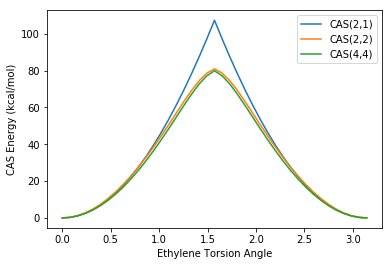

In [5]:
# Examine a CAS(n electrons, n spatial orbitals) active space - 2 x number spatial orbitals = qubits
angles = [float(filename.split('_')[-1].rstrip('.hdf5')) for filename in molecule_filenames]
cas_energies = {}
original_electrons = 16
for n_electrons, n_orbitals in [(2,1), (2,2), (4,4)]:
    occupied_indices = range(8 - n_electrons // 2)
    active_indices = range(8 - n_electrons // 2, 8 - n_electrons // 2 + n_orbitals)
    active_electrons = original_electrons - len(occupied_indices) * 2
    active_qubits = len(active_indices) * 2

    # Define a qubit number operator
    number_operator = get_sparse_operator(jordan_wigner(
        sum([FermionOperator( ((i, 1), (i, 0)), 1.0) for i in range(active_qubits)], FermionOperator()))).todense()
    spinx_operator = get_sparse_operator(jordan_wigner(
            sum([FermionOperator( ((2*i, 1), (2*i+1, 0)), 0.5) 
                 for i in range(active_qubits // 2)], FermionOperator()) +
            sum([FermionOperator( ((2*i+1, 1), (2*i, 0)), 0.5) 
                 for i in range(active_qubits // 2)], FermionOperator()))).todense()
    spiny_operator = get_sparse_operator(jordan_wigner(
            sum([FermionOperator( ((2*i, 1), (2*i+1, 0)), -0.5j) 
                 for i in range(active_qubits // 2)], FermionOperator()) +
            sum([FermionOperator( ((2*i+1, 1), (2*i, 0)), 0.5j) 
                 for i in range(active_qubits // 2)], FermionOperator()))).todense()
    spinz_operator = get_sparse_operator(jordan_wigner(
            sum([FermionOperator( ((2*i, 1), (2*i, 0)), 0.5) 
                 for i in range(active_qubits // 2)], FermionOperator()) +
            sum([FermionOperator( ((2*i+1, 1), (2*i+1, 0)), -0.5) 
                 for i in range(active_qubits // 2)], FermionOperator()))).todense()
    spin2_operator = (np.dot(spinx_operator, spinx_operator) +
                      np.dot(spiny_operator, spiny_operator) +
                      np.dot(spinz_operator, spinz_operator))
    cas_energies['CAS({},{})'.format(n_electrons, n_orbitals)] = []
    for filename in molecule_filenames:
        molecule = MolecularData(filename=filename)
        # Extract active space integrals
        hamiltonian = (molecule.
                       get_molecular_hamiltonian(
                           occupied_indices=occupied_indices,
                           active_indices=active_indices))
        fermion_hamiltonian = get_fermion_operator(hamiltonian)

        # Build qubit Hamiltonian
        qubit_hamiltonian = jordan_wigner(fermion_hamiltonian)

        # Build matrix representation & diagonalize
        qubit_hamiltonian_matrix = get_sparse_operator(hamiltonian).todense()

        # Project to S^2 = 0 subspace
        U_s2 = FindSymmTransform(spin2_operator, 
                                 np.eye(spin2_operator.shape[0]),
                                 0.0)
        qubit_hamiltonian_matrix = np.dot(np.conj(U_s2).T, np.dot(qubit_hamiltonian_matrix, U_s2))
        
        print('Qubit Hamiltonian Matrix')
        print(qubit_hamiltonian_matrix)
        print()
        
        eigvals, eigvecs = scipy.linalg.eigh(qubit_hamiltonian_matrix)
        ground_state = eigvecs[:,0][:, np.newaxis]
        energy = eigvals[0]
        number = reduce(np.dot,
                        (np.conj(ground_state.T), np.conj(U_s2).T, number_operator, U_s2, ground_state))[0,0]
        spinz =  reduce(np.dot,
                        (np.conj(ground_state.T), np.conj(U_s2).T, spinz_operator, U_s2, ground_state))[0,0]
        spin2 =  reduce(np.dot,
                       (np.conj(ground_state.T), np.conj(U_s2).T, spin2_operator, U_s2, ground_state))[0,0]
        
        cas_energies['CAS({},{})'.format(n_electrons, n_orbitals)].append(energy)
        print('Energy: {}\t Number: {}\t Sz:{}\t S^2:{}'.format(energy, number, spinz, spin2))
        
    
pylab.xlabel("Ethylene Torsion Angle")
pylab.ylabel("CAS Energy (kcal/mol)")
for key in cas_energies:                       
    pylab.plot(angles, 
               hartree_to_kcal * (np.array(cas_energies[key]) - cas_energies[key][0]),
               label=key)
pylab.legend()

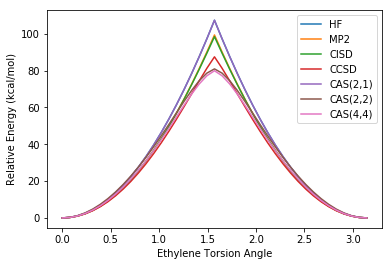

In [6]:
pylab.xlabel("Ethylene Torsion Angle")
pylab.ylabel("Relative Energy (kcal/mol)")
pylab.plot(angles, hartree_to_kcal * (np.array(hf_energies) - hf_energies[0]), label="HF")
pylab.plot(angles, hartree_to_kcal * (np.array(mp2_energies) - mp2_energies[0]), label="MP2")
pylab.plot(angles, hartree_to_kcal * (np.array(cisd_energies) - cisd_energies[0]), label="CISD")
pylab.plot(angles, hartree_to_kcal * (np.array(ccsd_energies) - ccsd_energies[0]), label="CCSD")
for key in cas_energies:                       
    pylab.plot(angles, 
               hartree_to_kcal * (np.array(cas_energies[key]) - cas_energies[key][0]),
               label=key)
pylab.legend()

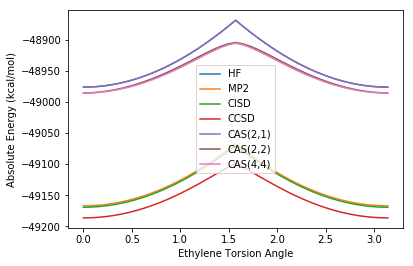

In [7]:
pylab.xlabel("Ethylene Torsion Angle")
pylab.ylabel("Absolute Energy (kcal/mol)")
pylab.plot(angles, hartree_to_kcal * np.array(hf_energies), label="HF")
pylab.plot(angles, hartree_to_kcal * np.array(mp2_energies), label="MP2")
pylab.plot(angles, hartree_to_kcal * np.array(cisd_energies), label="CISD")
pylab.plot(angles, hartree_to_kcal * np.array(ccsd_energies), label="CCSD")
for key in cas_energies:                       
    pylab.plot(angles, 
               hartree_to_kcal * np.array(cas_energies[key]),
               label=key)
pylab.legend()

In [8]:
# Make a UCC Singlet Ansatz for CAS(2,2) at a particular geometry
uccsd_energies = {}
uccsd_amplitudes = {}
original_electrons = 16
for n_electrons, n_orbitals in [(2,2)]:
    occupied_indices = range(8 - n_electrons // 2)
    active_indices = range(8 - n_electrons // 2, 8 - n_electrons // 2 + n_orbitals)
    active_electrons = original_electrons - len(occupied_indices) * 2
    active_qubits = len(active_indices) * 2

    # Define a qubit number operator
    number_operator = jordan_wigner(
        sum([FermionOperator( ((i, 1), (i, 0)), 1.0) for i in range(active_qubits)], FermionOperator()))
    number_operator.compress()
    spinz_operator = jordan_wigner(sum([FermionOperator( ((2*i, 1), (2*i, 0)), 0.5) 
                                        for i in range(active_qubits // 2)], FermionOperator()) +
                                   sum([FermionOperator( ((2*i+1, 1), (2*i+1, 0)), -0.5) 
                                        for i in range(active_qubits // 2)], FermionOperator()))
    spinz_operator.compress()
    
    n_amplitudes = int(uccsd_singlet_paramsize(active_qubits, 
                                           active_electrons))
    print("Running CAS({},{}) with {} coupled cluster amplitudes".format(n_electrons, n_orbitals,n_amplitudes))
    current_amplitudes = [0.0] * n_amplitudes + 0.001 * randn(n_amplitudes)
    uccsd_energies['CAS({},{})'.format(n_electrons, n_orbitals)] = []
    uccsd_amplitudes['CAS({},{})'.format(n_electrons, n_orbitals)] = []

    for file_index, filename in enumerate(molecule_filenames):
        print("Running CAS({},{}) on {}".format(n_electrons, n_orbitals, filename))
        molecule = MolecularData(filename=filename)
        # Extract active space integrals
        hamiltonian = (molecule.
                       get_molecular_hamiltonian(
                           occupied_indices=occupied_indices,
                           active_indices=active_indices))
        fermion_hamiltonian = get_fermion_operator(hamiltonian)


        # Use a Jordan-Wigner encoding, and compress to remove 0 imaginary components
        qubit_hamiltonian = jordan_wigner(fermion_hamiltonian)
        qubit_hamiltonian.compress()
        
        # Set standard UCCSD Compiler engine
        compiler_engine = uccsd_trotter_engine()

        def energy_objective(packed_amplitudes):
            """Evaluate the energy of a UCCSD singlet wavefunction with packed_amplitudes
            Args:
                packed_amplitudes(ndarray): Compact array that stores the unique
                    amplitudes for a UCCSD singlet wavefunction.

            Returns:
                energy(float): Energy corresponding to the given amplitudes
            """
            # Set Jordan-Wigner initial state with correct number of electrons
            wavefunction = compiler_engine.allocate_qureg(active_qubits)
            
            # Set some of the qubits to |1>, or occupied
            for i in range(active_electrons):
                X | wavefunction[i]

            # Build the circuit and act it on the wavefunction
            evolution_operator = uccsd_singlet_evolution(packed_amplitudes, 
                                                         active_qubits, 
                                                         active_electrons)
            evolution_operator | wavefunction
            compiler_engine.flush()

            # Evaluate the energy and reset wavefunction
            energy = compiler_engine.backend.get_expectation_value(qubit_hamiltonian, wavefunction)
            number = compiler_engine.backend.get_expectation_value(number_operator, wavefunction)
            spinz = compiler_engine.backend.get_expectation_value(spinz_operator, wavefunction)
            print("Energy: {}\t Number:{}\t Sz:{}".format(energy, number, spinz))
            All(Measure) | wavefunction
            compiler_engine.flush()
            return energy

        initial_energy = energy_objective(current_amplitudes)

        # Run VQE Optimization to find new CCSD parameters
        opt_result = minimize(energy_objective, current_amplitudes,
                              method="l-bfgs-b", options={'disp':True})

        opt_energy, opt_amplitudes = opt_result.fun, opt_result.x

        # Use previous interation as guess for next iteration
        current_amplitudes = opt_amplitudes[:]

        # Store energy and amplitudes
        uccsd_energies['CAS({},{})'.format(n_electrons, n_orbitals)].append(opt_energy)
        uccsd_amplitudes['CAS({},{})'.format(n_electrons, n_orbitals)].append([opt_amplitudes])

        print("\nInitial Energy: {}".format(initial_energy))
        print("Optimal UCCSD Singlet Energy: {}".format(opt_energy))
        print("Optimal UCCSD Singlet Amplitudes: {}".format(opt_amplitudes))
        print("Exact FCI Energy: {} Hartrees".format(
                cas_energies['CAS({},{})'.format(n_electrons, n_orbitals)][file_index]))


Running CAS(2,2) with 2 coupled cluster amplitudes
Running CAS(2,2) on data/H4-C2_DZP_singlet_ethylene_0.00000.hdf5
Energy: -78.04918357154226	 Number:1.999999999999991	 Sz:0.0
Energy: -78.04918357154226	 Number:1.999999999999991	 Sz:0.0
Energy: -78.04918357154361	 Number:1.9999999999999911	 Sz:0.0
Energy: -78.04918357512665	 Number:1.9999999999999905	 Sz:0.0
Energy: -77.53800904934	 Number:1.9999999999999916	 Sz:0.0
Energy: -77.53800904934039	 Number:1.9999999999999911	 Sz:0.0
Energy: -77.53800905511343	 Number:1.9999999999999927	 Sz:0.0
Energy: -78.06341300522556	 Number:1.999999999999989	 Sz:0.0
Energy: -78.06341300522634	 Number:1.9999999999999885	 Sz:0.0
Energy: -78.0634130057875	 Number:1.999999999999992	 Sz:0.0
Energy: -78.06376201687046	 Number:1.9999999999999931	 Sz:0.0
Energy: -78.06376201687085	 Number:1.9999999999999913	 Sz:0.0
Energy: -78.06376201685885	 Number:1.9999999999999907	 Sz:0.0
Energy: -78.06376216470919	 Number:1.9999999999999911	 Sz:0.0
Energy: -78.063762164709

Energy: -78.02761769764024	 Number:1.9999999999999896	 Sz:0.0
Energy: -77.69108249299029	 Number:1.9999999999999907	 Sz:0.0
Energy: -77.69108249298885	 Number:1.9999999999999902	 Sz:0.0
Energy: -77.691082499022	 Number:1.9999999999999902	 Sz:0.0
Energy: -78.02764341231172	 Number:1.9999999999999911	 Sz:0.0
Energy: -78.02764341231173	 Number:1.9999999999999916	 Sz:0.0
Energy: -78.02764341231297	 Number:1.9999999999999907	 Sz:0.0
Energy: -78.02764341475306	 Number:1.9999999999999885	 Sz:0.0
Energy: -78.02764341475314	 Number:1.9999999999999916	 Sz:0.0
Energy: -78.02764341475321	 Number:1.9999999999999925	 Sz:0.0

Initial Energy: -78.0276176975114
Optimal UCCSD Singlet Energy: -78.02764341475306
Optimal UCCSD Singlet Amplitudes: [  1.88560724e-06   9.48942741e-02]
Exact FCI Energy: -78.02764341475537 Hartrees
Running CAS(2,2) on data/H4-C2_DZP_singlet_ethylene_0.78540.hdf5
Energy: -78.019752702625	 Number:1.9999999999999885	 Sz:0.0
Energy: -78.019752702625	 Number:1.9999999999999885	 Sz:0

Energy: -77.79733074984765	 Number:1.9999999999999911	 Sz:0.0
Energy: -77.79733074984746	 Number:1.9999999999999893	 Sz:0.0
Energy: -77.79733075226733	 Number:1.9999999999999882	 Sz:0.0
Energy: -77.95338147376329	 Number:1.9999999999999898	 Sz:0.0
Energy: -77.95338147376334	 Number:1.9999999999999902	 Sz:0.0
Energy: -77.95338147379249	 Number:1.999999999999992	 Sz:0.0
Energy: -77.95338441189254	 Number:1.999999999999991	 Sz:0.0
Energy: -77.95338441189259	 Number:1.9999999999999907	 Sz:0.0
Energy: -77.95338441189226	 Number:1.9999999999999887	 Sz:0.0
Energy: -77.95338441209479	 Number:1.9999999999999913	 Sz:0.0
Energy: -77.95338441209478	 Number:1.9999999999999911	 Sz:0.0
Energy: -77.95338441209486	 Number:1.9999999999999925	 Sz:0.0

Initial Energy: -77.95275211704435
Optimal UCCSD Singlet Energy: -77.95338441209479
Optimal UCCSD Singlet Amplitudes: [  2.56176400e-07   2.08609400e-01]
Exact FCI Energy: -77.95338441210059 Hartrees
Running CAS(2,2) on data/H4-C2_DZP_singlet_ethylene_1.413


Initial Energy: -77.96215275915765
Optimal UCCSD Singlet Energy: -77.96287140310133
Optimal UCCSD Singlet Amplitudes: [  1.97795198e-06   1.78928577e-01]
Exact FCI Energy: -77.9628714031078 Hartrees
Running CAS(2,2) on data/H4-C2_DZP_singlet_ethylene_1.96350.hdf5
Energy: -77.97236703190985	 Number:1.9999999999999918	 Sz:0.0
Energy: -77.97236703190985	 Number:1.9999999999999918	 Sz:0.0
Energy: -77.97236703190973	 Number:1.999999999999989	 Sz:0.0
Energy: -77.97236703149224	 Number:1.9999999999999898	 Sz:0.0
Energy: -77.7744430368271	 Number:1.9999999999999931	 Sz:0.0
Energy: -77.77444303682583	 Number:1.9999999999999918	 Sz:0.0
Energy: -77.77444303362141	 Number:1.9999999999999931	 Sz:0.0
Energy: -77.97283882590405	 Number:1.9999999999999916	 Sz:0.0
Energy: -77.97283882590415	 Number:1.999999999999993	 Sz:0.0
Energy: -77.9728388258819	 Number:1.9999999999999907	 Sz:0.0
Energy: -77.9728401491015	 Number:1.9999999999999916	 Sz:0.0
Energy: -77.97284014910157	 Number:1.9999999999999933	 Sz:


Initial Energy: -78.02760085109418
Optimal UCCSD Singlet Energy: -78.02764341474698
Optimal UCCSD Singlet Amplitudes: [  5.13113396e-07   9.48966435e-02]
Exact FCI Energy: -78.0276434147554 Hartrees
Running CAS(2,2) on data/H4-C2_DZP_singlet_ethylene_2.51327.hdf5
Energy: -78.03479670935792	 Number:1.9999999999999898	 Sz:0.0
Energy: -78.03479670935792	 Number:1.9999999999999898	 Sz:0.0
Energy: -78.03479670935805	 Number:1.9999999999999922	 Sz:0.0
Energy: -78.03479670922013	 Number:1.9999999999999927	 Sz:0.0
Energy: -77.67524783339557	 Number:1.9999999999999902	 Sz:0.0
Energy: -77.67524783340461	 Number:1.9999999999999905	 Sz:0.0
Energy: -77.67524782695149	 Number:1.99999999999999	 Sz:0.0
Energy: -78.03482425086446	 Number:1.999999999999991	 Sz:0.0
Energy: -78.03482425086439	 Number:1.9999999999999905	 Sz:0.0
Energy: -78.03482425086318	 Number:1.999999999999993	 Sz:0.0
Energy: -78.03482425359157	 Number:1.9999999999999938	 Sz:0.0
Energy: -78.03482425359142	 Number:1.9999999999999902	 Sz

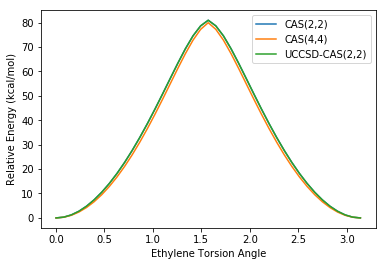

In [9]:
pylab.xlabel("Ethylene Torsion Angle")
pylab.ylabel("Relative Energy (kcal/mol)")
for key in ['CAS(2,2)', 'CAS(4,4)']: #cas_energies:                       
    pylab.plot(angles, 
               hartree_to_kcal * (np.array(cas_energies[key]) - cas_energies[key][0]),
              label=key)
for key in uccsd_energies:                       
    pylab.plot(angles, 
               hartree_to_kcal * (np.array(uccsd_energies[key]) - uccsd_energies[key][0]),
               label="UCCSD-" + key)
pylab.legend()
pylab.savefig("Ethylene_UCCSD_4Qubit.pdf")

In [10]:
# Print out the commands submitted to the engine
cmd_printer = _printer.CommandPrinter()
active_qubits = 4
active_electrons = 2
n_amplitudes = int(uccsd_singlet_paramsize(active_qubits, active_electrons))
packed_amplitudes = [0.0] * n_amplitudes + 0.001 * randn(n_amplitudes)
compiler_engine = uccsd_trotter_engine(cmd_printer)
wavefunction = []
wavefunction = compiler_engine.allocate_qureg(active_qubits)
for i in range(active_electrons):
    X | wavefunction[i]
evolution_operator = uccsd_singlet_evolution(packed_amplitudes, active_qubits, active_electrons)
evolution_operator | wavefunction
compiler_engine.flush()

Allocate | Qureg[0]
Allocate | Qureg[1]
Allocate | Qureg[2]
Allocate | Qureg[3]
X | Qureg[0]
X | Qureg[1]
Rx(1.5707963267948966) | Qureg[0]
H | Qureg[2]
CX | ( Qureg[0], Qureg[1] )
CX | ( Qureg[1], Qureg[2] )
Rz(12.56551003804646) | Qureg[2]
CX | ( Qureg[1], Qureg[2] )
CX | ( Qureg[0], Qureg[1] )
H | Qureg[2]
Rx(10.995574287564276) | Qureg[0]
H | Qureg[0]
Rx(1.5707963267948966) | Qureg[2]
CX | ( Qureg[0], Qureg[1] )
CX | ( Qureg[1], Qureg[2] )
Rz(0.0008605763127126801) | Qureg[2]
CX | ( Qureg[1], Qureg[2] )
CX | ( Qureg[0], Qureg[1] )
Rx(10.995574287564276) | Qureg[2]
H | Qureg[0]
Rx(1.5707963267948966) | Qureg[1]
H | Qureg[3]
CX | ( Qureg[1], Qureg[2] )
CX | ( Qureg[2], Qureg[3] )
Rz(12.56551003804646) | Qureg[3]
CX | ( Qureg[2], Qureg[3] )
CX | ( Qureg[1], Qureg[2] )
H | Qureg[3]
Rx(10.995574287564276) | Qureg[1]
H | Qureg[1]
Rx(1.5707963267948966) | Qureg[3]
CX | ( Qureg[1], Qureg[2] )
CX | ( Qureg[2], Qureg[3] )
Rz(0.0008605763127126801) | Qureg[3]
CX | ( Qureg[2], Qureg[3] )
CX | 

In [11]:
# Generate the circuit diagram and print it
drawer = CircuitDrawer()
active_qubits = 4
active_electrons = 2
n_amplitudes = int(uccsd_singlet_paramsize(active_qubits, active_electrons))
packed_amplitudes = [0.0] * n_amplitudes + 0.001 * randn(n_amplitudes)
compiler_engine = uccsd_trotter_engine(drawer)
wavefunction = []
wavefunction = compiler_engine.allocate_qureg(active_qubits)
for i in range(active_electrons):
    X | wavefunction[i]
evolution_operator = uccsd_singlet_evolution(packed_amplitudes, active_qubits, active_electrons)
evolution_operator | wavefunction
compiler_engine.flush()
circuit = drawer.get_latex()
print(circuit)

Deallocate | Qureg[3]
Deallocate | Qureg[2]
Deallocate | Qureg[1]
Deallocate | Qureg[0]
\documentclass{standalone}
\usepackage[margin=1in]{geometry}
\usepackage[hang,small,bf]{caption}
\usepackage{tikz}
\usepackage{braket}
\usetikzlibrary{backgrounds,shadows.blur,fit,decorations.pathreplacing,shapes}

\begin{document}
\begin{tikzpicture}[scale=0.8, transform shape]

\tikzstyle{basicshadow}=[blur shadow={shadow blur steps=8, shadow xshift=0.7pt, shadow yshift=-0.7pt, shadow scale=1.02}]\tikzstyle{basic}=[draw,fill=white,basicshadow]
\tikzstyle{operator}=[basic,minimum size=1.5em]
\tikzstyle{phase}=[fill=black,shape=circle,minimum size=0.1cm,inner sep=0pt,outer sep=0pt,draw=black]
\tikzstyle{none}=[inner sep=0pt,outer sep=-.5pt,minimum height=0.5cm+1pt]
\tikzstyle{measure}=[operator,inner sep=0pt,minimum height=0.5cm, minimum width=0.75cm]
\tikzstyle{xstyle}=[circle,basic,minimum height=0.35cm,minimum width=0.35cm,inner sep=0pt,very thin]
\tikzset{
shadowed/.style={preaction={transform c

In [12]:
# Make a custom ansatz for CAS(2,2) at a particular geometry
# UCCSD has only one single and one double excitation operator; The custom ansatz only tackles the double exitation
from projectq import MainEngine
from projectq.ops import H, X, Rz, Rx, CNOT
from projectq.meta import Control

mini_energies = {}
mini_amplitudes = {}
original_electrons = 16
n_electrons = 2
n_orbitals = 2
for target_flip in range(4):
    print("\n\nTarget flip {} ...\n\n".format(target_flip))
    occupied_indices = range(8 - n_electrons // 2)
    active_indices = range(8 - n_electrons // 2, 8 - n_electrons // 2 + n_orbitals)
    active_electrons = original_electrons - len(occupied_indices) * 2
    active_qubits = len(active_indices) * 2

    # Define a qubit number operator
    number_operator = jordan_wigner(
        sum([FermionOperator( ((i, 1), (i, 0)), 1.0) for i in range(active_qubits)], FermionOperator()))
    number_operator.compress()
    spinz_operator = jordan_wigner(sum([FermionOperator( ((2*i, 1), (2*i, 0)), 0.5) 
                                        for i in range(active_qubits // 2)], FermionOperator()) +
                                   sum([FermionOperator( ((2*i+1, 1), (2*i+1, 0)), -0.5) 
                                        for i in range(active_qubits // 2)], FermionOperator()))
    spinz_operator.compress()

    n_amplitudes = 1
    current_amplitudes = [0.0] * n_amplitudes + 0.001 * randn(n_amplitudes)
    
    # Printout formatting
    mini_energies['CAS({},{})-{}'.format(n_electrons, n_orbitals, target_flip)] = []
    mini_amplitudes['CAS({},{})-{}'.format(n_electrons, n_orbitals, target_flip)] = []

    for file_index, filename in enumerate(molecule_filenames):
        print("Running CAS({},{}) on {}".format(n_electrons, n_orbitals, filename))
        molecule = MolecularData(filename=filename)
            
        # Extract active space integrals
        hamiltonian = (molecule.
                        get_molecular_hamiltonian(
                        occupied_indices=occupied_indices,
                        active_indices=active_indices))
        fermion_hamiltonian = get_fermion_operator(hamiltonian)

        # For comparison, do a Bravyi-Kitaev encoding, compress to remove 0 imaginary components and print
        qubit_hamiltonian = bravyi_kitaev(fermion_hamiltonian)
        qubit_hamiltonian.compress()
        print('Bravyi-Kitaev')
        print(qubit_hamiltonian)
        
        # Use a Jordan-Wigner encoding, and compress to remove 0 imaginary components and print
        qubit_hamiltonian = jordan_wigner(fermion_hamiltonian)
        qubit_hamiltonian.compress()
        print('Jordan-Wigner')
        print(qubit_hamiltonian)
        
        # Set standard UCCSD Compiler engine
        compiler_engine = MainEngine()

        def energy_objective(packed_amplitudes):
            """Evaluate the energy of a mini singlet wavefunction with packed_amplitudes
                Args:
                packed_amplitudes(ndarray): Compact array that stores the unique
                    amplitudes

                Returns:
                    energy(float): Energy corresponding to the given amplitudes
            """
            
            # Allocate qubits
            wavefunction = compiler_engine.allocate_qureg(active_qubits)

            # Set Jordan-Wigner initial state with correct number of electrons 
            for i in range(active_electrons):
                X | wavefunction[i]

            # Build the circuit and act it on the wavefunction
            # Apply Hadamard gate to all qubits
            for i in range(active_qubits):
                H | wavefunction[i]

            # Undo the Hadamard on one qubit and apply Rx
            H | wavefunction[target_flip]
            Rx(-np.pi/2) | wavefunction[target_flip]

            # Entangle qubits with CNOTs
            for i in range(active_qubits-1):
                CNOT | (wavefunction[i], wavefunction[i+1])
            
            # UCCSD exponent rotation Rz
            Rz(packed_amplitudes[0]) | wavefunction[active_qubits-1]

            # Reverse CNOTs
            for i in reversed(range(active_qubits-1)):
                CNOT | (wavefunction[i], wavefunction[i+1])

            # Undo Hadamard
            for i in range(active_qubits):
                H | wavefunction[i]

            # Rotate the one qubit back with -Rx
            H | wavefunction[target_flip]
            Rx(np.pi/2) | wavefunction[target_flip]

            # Reset of qubits
            compiler_engine.flush()

            # Evaluate the energy and reset wavefunction
            energy = compiler_engine.backend.get_expectation_value(qubit_hamiltonian, wavefunction)
            number = compiler_engine.backend.get_expectation_value(number_operator, wavefunction)
            spinz = compiler_engine.backend.get_expectation_value(spinz_operator, wavefunction)
            print("Energy: {}\t Number:{}\t Sz:{}".format(energy, number, spinz))
            All(Measure) | wavefunction
            compiler_engine.flush()
            return energy

        initial_energy = energy_objective(current_amplitudes)

        # Run VQE Optimization to find new CCSD parameters
        opt_result = minimize(energy_objective, current_amplitudes,
                                method="l-bfgs-b", options={'disp':True})

        opt_energy, opt_amplitudes = opt_result.fun, opt_result.x

        # Use previous interation as guess for next iteration
        current_amplitudes = opt_amplitudes[:]

        # Store energy and amplitudes
        mini_energies['CAS({},{})-{}'.format(n_electrons, n_orbitals, target_flip)].append(opt_energy)
        mini_amplitudes['CAS({},{})-{}'.format(n_electrons, n_orbitals, target_flip)].append([opt_amplitudes])

        print("\nInitial Energy: {}".format(initial_energy))
        print("Optimal mini Singlet Energy: {}".format(opt_energy))
        print("Optimal mini Singlet Amplitudes: {}".format(opt_amplitudes))
        print("Exact FCI Energy: {} Hartrees".format(
                cas_energies['CAS({},{})'.format(n_electrons, n_orbitals)][file_index]))



Target flip 0 ...


Running CAS(2,2) on data/H4-C2_DZP_singlet_ethylene_0.00000.hdf5
Bravyi-Kitaev
-77.65548161283827 I +
0.13679735356084918 Z0 +
0.13679735356084918 Z0 Z1 +
0.002875889786766783 Z2 +
0.0028758897867667416 Z1 Z2 Z3 +
0.06811794699534135 Z0 Z2 +
0.1097160266993254 Z1 +
0.022600900279908097 Y0 Z1 Y2 Z3 +
0.022600900279908097 X0 Z1 X2 +
0.022600900279908097 X0 Z1 X2 Z3 +
0.022600900279908097 Y0 Z1 Y2 +
0.09071884727524945 Z0 Z1 Z2 Z3 +
0.06811794699534135 Z0 Z2 Z3 +
0.09071884727524945 Z0 Z1 Z2 +
0.08236525639700065 Z1 Z3
Jordan-Wigner
-77.65548161283827 I +
0.13679735356084918 Z0 +
0.13679735356084918 Z1 +
0.002875889786766783 Z2 +
0.0028758897867667416 Z3 +
0.06811794699534135 Z0 Z2 +
0.1097160266993254 Z0 Z1 +
0.022600900279908097 Y0 X1 X2 Y3 +
-0.022600900279908097 Y0 Y1 X2 X3 +
-0.022600900279908097 X0 X1 Y2 Y3 +
0.022600900279908097 X0 Y1 Y2 X3 +
0.09071884727524945 Z0 Z3 +
0.06811794699534135 Z1 Z3 +
0.09071884727524945 Z1 Z2 +
0.08236525639700065 Z2 Z3
Energy: -

Energy: -77.93671620787357	 Number:1.999999999999998	 Sz:0.0
Energy: -78.05198481925008	 Number:1.9999999999999987	 Sz:0.0
Energy: -78.05198481924924	 Number:1.9999999999999976	 Sz:0.0
Energy: -78.05198483214242	 Number:1.9999999999999976	 Sz:0.0
Energy: -78.05198483214247	 Number:1.9999999999999984	 Sz:0.0

Initial Energy: -78.05198227844275
Optimal mini Singlet Energy: -78.05198483214242
Optimal mini Singlet Amplitudes: [-0.33574864]
Exact FCI Energy: -78.05198483216614 Hartrees
Running CAS(2,2) on data/H4-C2_DZP_singlet_ethylene_0.47124.hdf5
Bravyi-Kitaev
-77.67436158080608 I +
0.12349745359197184 Z0 +
0.1234974535919719 Z0 Z1 +
0.00976015292291757 Z2 +
0.00976015292291757 Z1 Z2 Z3 +
0.06971302028404606 Z0 Z2 +
0.10548208417112828 Z1 +
0.020263196285854376 Y0 Z1 Y2 Z3 +
0.020263196285854376 X0 Z1 X2 +
0.020263196285854376 X0 Z1 X2 Z3 +
0.020263196285854376 Y0 Z1 Y2 +
0.08997621656990044 Z0 Z1 Z2 Z3 +
0.06971302028404606 Z0 Z2 Z3 +
0.08997621656990044 Z0 Z1 Z2 +
0.08271282400627147 Z

Exact FCI Energy: -78.01979227303342 Hartrees
Running CAS(2,2) on data/H4-C2_DZP_singlet_ethylene_0.86394.hdf5
Bravyi-Kitaev
-77.70046456148738 I +
0.10222799552148318 Z0 +
0.10222799552148315 Z0 Z1 +
0.023343001510191863 Z2 +
0.023343001510191905 Z1 Z2 Z3 +
0.07160038132576145 Z0 Z2 +
0.10086582539389298 Z1 +
0.017910433005379145 Y0 Z1 Y2 Z3 +
0.017910433005379145 X0 Z1 X2 +
0.017910433005379145 X0 Z1 X2 Z3 +
0.017910433005379145 Y0 Z1 Y2 +
0.0895108143311406 Z0 Z1 Z2 Z3 +
0.07160038132576145 Z0 Z2 Z3 +
0.0895108143311406 Z0 Z1 Z2 +
0.08377793697923139 Z1 Z3
Jordan-Wigner
-77.70046456148738 I +
0.10222799552148318 Z0 +
0.10222799552148315 Z1 +
0.023343001510191863 Z2 +
0.023343001510191905 Z3 +
0.07160038132576145 Z0 Z2 +
0.10086582539389298 Z0 Z1 +
0.017910433005379145 Y0 X1 X2 Y3 +
-0.017910433005379145 Y0 Y1 X2 X3 +
-0.017910433005379145 X0 X1 Y2 Y3 +
0.017910433005379145 X0 Y1 Y2 X3 +
0.0895108143311406 Z0 Z3 +
0.07160038132576145 Z1 Z3 +
0.0895108143311406 Z1 Z2 +
0.0837779369792

Energy: -77.91670892445403	 Number:1.999999999999998	 Sz:0.0
Energy: -77.93845121916682	 Number:1.9999999999999982	 Sz:0.0
Energy: -77.93845121916142	 Number:1.999999999999998	 Sz:0.0
Energy: -77.93845326209056	 Number:1.9999999999999984	 Sz:0.0
Energy: -77.93845326209058	 Number:1.9999999999999978	 Sz:0.0

Initial Energy: -77.93706867164737
Optimal mini Singlet Energy: -77.93845326209056
Optimal mini Singlet Amplitudes: [-1.18711597]
Exact FCI Energy: -77.93845326221081 Hartrees
Running CAS(2,2) on data/H4-C2_DZP_singlet_ethylene_1.57080.hdf5
Bravyi-Kitaev
-77.72416816338412 I +
0.060257486230092576 Z0 +
-4.4068297315753805e-08 X0 Y1 Y2 +
4.4068297315753805e-08 Y0 Y1 X2 +
0.0602574862300926 Z0 Z1 +
4.4068297315753805e-08 Z0 X1 Z3 +
-4.4068297315753805e-08 X1 Z2 +
0.05532750645526676 Z2 +
0.05532750645526676 Z1 Z2 Z3 +
0.0733960094518539 Z0 Z2 +
4.295834293305956e-08 X1 Z3 +
-4.295834293305956e-08 Z0 X1 Z2 +
0.09540148775845296 Z1 +
-4.295834293305956e-08 Y0 X1 Y2 +
-4.295834293305956e

Exact FCI Energy: -77.97284014912026 Hartrees
Running CAS(2,2) on data/H4-C2_DZP_singlet_ethylene_2.04204.hdf5
Bravyi-Kitaev
-77.71300080914992 I +
0.08835520033913943 Z0 +
0.08835520033913942 Z0 Z1 +
0.0333601465685755 Z2 +
0.03336014656857546 Z1 Z2 Z3 +
0.0724449960344307 Z0 Z2 +
0.09870605064962905 Z1 +
0.017070036609301703 Y0 Z1 Y2 Z3 +
0.017070036609301703 X0 Z1 X2 +
0.017070036609301703 X0 Z1 X2 Z3 +
0.017070036609301703 Y0 Z1 Y2 +
0.0895150326437324 Z0 Z1 Z2 Z3 +
0.0724449960344307 Z0 Z2 Z3 +
0.0895150326437324 Z0 Z1 Z2 +
0.08478275639192928 Z1 Z3
Jordan-Wigner
-77.71300080914992 I +
0.08835520033913943 Z0 +
0.08835520033913942 Z1 +
0.0333601465685755 Z2 +
0.03336014656857546 Z3 +
0.0724449960344307 Z0 Z2 +
0.09870605064962905 Z0 Z1 +
0.017070036609301703 Y0 X1 X2 Y3 +
-0.017070036609301703 Y0 Y1 X2 X3 +
-0.017070036609301703 X0 X1 Y2 Y3 +
0.017070036609301703 X0 Y1 Y2 X3 +
0.0895150326437324 Z0 Z3 +
0.0724449960344307 Z1 Z3 +
0.0895150326437324 Z1 Z2 +
0.08478275639192928 Z2 Z3

Jordan-Wigner
-77.67963753269835 I +
0.11959072293275701 Z0 +
0.11959072293275708 Z1 +
0.012047226048714388 Z2 +
0.012047226048714374 Z3 +
0.07011941140222372 Z0 Z2 +
0.10446959994283171 Z0 Z1 +
0.019713515623995273 Y0 X1 X2 Y3 +
-0.019713515623995273 Y0 Y1 X2 X3 +
-0.019713515623995273 X0 X1 Y2 Y3 +
0.019713515623995273 X0 Y1 Y2 X3 +
0.08983292702621898 Z0 Z3 +
0.07011941140222372 Z1 Z3 +
0.08983292702621898 Z1 Z2 +
0.08286139350155984 Z2 Z3
Energy: -78.04128005905167	 Number:1.999999999999998	 Sz:0.0
Energy: -78.04128005905167	 Number:1.999999999999998	 Sz:0.0
Energy: -78.0412800590796	 Number:1.9999999999999982	 Sz:0.0
Energy: -77.93833424782277	 Number:1.9999999999999984	 Sz:0.0
Energy: -77.93833424591034	 Number:1.9999999999999982	 Sz:0.0
Energy: -78.0412970929432	 Number:1.9999999999999984	 Sz:0.0
Energy: -78.0412970929452	 Number:1.999999999999999	 Sz:0.0
Energy: -78.04129717824765	 Number:1.999999999999999	 Sz:0.0
Energy: -78.0412971782476	 Number:1.9999999999999987	 Sz:0.0

In

Energy: -78.06327275232668	 Number:1.9999999999999978	 Sz:0.0
Energy: -78.06327275232668	 Number:1.9999999999999987	 Sz:0.0

Initial Energy: -78.06327274233536
Optimal mini Singlet Energy: -78.06327275232668
Optimal mini Singlet Amplitudes: [-0.32576011]
Exact FCI Energy: -78.06327275237307 Hartrees
Running CAS(2,2) on data/H4-C2_DZP_singlet_ethylene_0.15708.hdf5
Bravyi-Kitaev
-77.6579921811035 I +
0.13506373193189294 Z0 +
0.13506373193189297 Z0 Z1 +
0.003686903323145127 Z2 +
0.0036869033231450993 Z1 Z2 Z3 +
0.06834402802462934 Z0 Z2 +
0.10908527502167731 Z1 +
0.02225380448679667 Y0 Z1 Y2 Z3 +
0.02225380448679667 X0 Z1 X2 +
0.02225380448679667 X0 Z1 X2 Z3 +
0.02225380448679667 Y0 Z1 Y2 +
0.090597832511426 Z0 Z1 Z2 Z3 +
0.06834402802462934 Z0 Z2 Z3 +
0.090597832511426 Z0 Z1 Z2 +
0.08239742347428329 Z1 Z3
Jordan-Wigner
-77.6579921811035 I +
0.13506373193189294 Z0 +
0.13506373193189297 Z1 +
0.003686903323145127 Z2 +
0.0036869033231450993 Z3 +
0.06834402802462934 Z0 Z2 +
0.1090852750216773

Exact FCI Energy: -77.9927645882242 Hartrees
Running CAS(2,2) on data/H4-C2_DZP_singlet_ethylene_1.09956.hdf5
Bravyi-Kitaev
-77.71300080914996 I +
0.08835520033912594 Z0 +
0.08835520033912594 Z0 Z1 +
0.03336014656857786 Z2 +
0.03336014656857786 Z1 Z2 Z3 +
0.07244499603443104 Z0 Z2 +
0.09870605064962926 Z1 +
0.01707003660930123 Y0 Z1 Y2 Z3 +
0.01707003660930123 X0 Z1 X2 +
0.01707003660930123 X0 Z1 X2 Z3 +
0.01707003660930123 Y0 Z1 Y2 +
0.08951503264373227 Z0 Z1 Z2 Z3 +
0.07244499603443104 Z0 Z2 Z3 +
0.08951503264373227 Z0 Z1 Z2 +
0.08478275639192878 Z1 Z3
Jordan-Wigner
-77.71300080914996 I +
0.08835520033912594 Z0 +
0.08835520033912594 Z1 +
0.03336014656857786 Z2 +
0.03336014656857786 Z3 +
0.07244499603443104 Z0 Z2 +
0.09870605064962926 Z0 Z1 +
0.01707003660930123 Y0 X1 X2 Y3 +
-0.01707003660930123 Y0 Y1 X2 X3 +
-0.01707003660930123 X0 X1 Y2 Y3 +
0.01707003660930123 X0 Y1 Y2 X3 +
0.08951503264373227 Z0 Z3 +
0.07244499603443104 Z1 Z3 +
0.08951503264373227 Z1 Z2 +
0.08478275639192878 Z2 Z

0.08408502025678449 Z1 Z3
Jordan-Wigner
-77.70505918726832 I +
0.09764751744937257 Z0 +
0.09764751744937257 Z1 +
0.02657070990607259 Z2 +
0.026570709906072548 Z3 +
0.07190980670562595 Z0 Z2 +
0.10009833011849027 Z0 Z1 +
0.01758242716164022 Y0 X1 X2 Y3 +
-0.01758242716164022 Y0 Y1 X2 X3 +
-0.01758242716164022 X0 X1 Y2 Y3 +
0.01758242716164022 X0 Y1 Y2 X3 +
0.08949223386726617 Z0 Z3 +
0.07190980670562595 Z1 Z3 +
0.08949223386726617 Z1 Z2 +
0.08408502025678449 Z2 Z3
Energy: -78.002138524407	 Number:1.9999999999999976	 Sz:0.0
Energy: -78.002138524407	 Number:1.9999999999999976	 Sz:0.0
Energy: -78.00213852447395	 Number:1.9999999999999984	 Sz:0.0
Energy: -77.93492693204176	 Number:1.9999999999999978	 Sz:0.0
Energy: -77.93492693074452	 Number:1.9999999999999987	 Sz:0.0
Energy: -78.00227922780589	 Number:1.9999999999999982	 Sz:0.0
Energy: -78.00227922781012	 Number:1.9999999999999991	 Sz:0.0
Energy: -78.00227978623835	 Number:1.9999999999999984	 Sz:0.0
Energy: -78.00227978623828	 Number:1.999

Energy: -78.05612924703948	 Number:1.9999999999999984	 Sz:0.0

Initial Energy: -78.05612812858837
Optimal mini Singlet Energy: -78.05612924703948
Optimal mini Singlet Amplitudes: [ 0.3312244]
Exact FCI Energy: -78.05612924707025 Hartrees
Running CAS(2,2) on data/H4-C2_DZP_singlet_ethylene_0.39270.hdf5
Bravyi-Kitaev
-77.6693562835849 I +
0.12710408729725994 Z0 +
0.12710408729725997 Z0 Z1 +
0.00774900505835914 Z2 +
0.007749005058359133 Z1 Z2 Z3 +
0.06931269104285279 Z0 Z2 +
0.10650160032462003 Z1 +
0.020824200955257735 Y0 Z1 Y2 Z3 +
0.020824200955257735 X0 Z1 X2 +
0.020824200955257735 X0 Z1 X2 Z3 +
0.020824200955257735 Y0 Z1 Y2 +
0.09013689199811054 Z0 Z1 Z2 Z3 +
0.06931269104285279 Z0 Z2 Z3 +
0.09013689199811054 Z0 Z1 Z2 +
0.0825948468529845 Z1 Z3
Jordan-Wigner
-77.6693562835849 I +
0.12710408729725994 Z0 +
0.12710408729725997 Z1 +
0.00774900505835914 Z2 +
0.007749005058359133 Z3 +
0.06931269104285279 Z0 Z2 +
0.10650160032462003 Z0 Z1 +
0.020824200955257735 Y0 X1 X2 Y3 +
-0.020824200955

Energy: -77.98257953646616	 Number:1.9999999999999982	 Sz:0.0
Energy: -77.98257953646616	 Number:1.9999999999999982	 Sz:0.0
Energy: -77.98257953637619	 Number:1.9999999999999987	 Sz:0.0
Energy: -77.93078076745574	 Number:1.9999999999999982	 Sz:0.0
Energy: -77.9307807684939	 Number:1.9999999999999987	 Sz:0.0
Energy: -77.98289141007983	 Number:1.9999999999999982	 Sz:0.0
Energy: -77.98289141007457	 Number:1.999999999999999	 Sz:0.0
Energy: -77.9828924864337	 Number:1.999999999999998	 Sz:0.0
Energy: -77.98289248643367	 Number:1.9999999999999982	 Sz:0.0

Initial Energy: -77.98257953646616
Optimal mini Singlet Energy: -77.9828924864337
Optimal mini Singlet Amplitudes: [ 0.55557635]
Exact FCI Energy: -77.98289248644681 Hartrees
Running CAS(2,2) on data/H4-C2_DZP_singlet_ethylene_2.12058.hdf5
Bravyi-Kitaev
-77.70925553998894 I +
0.09301828621131757 Z0 +
0.09301828621131757 Z0 Z1 +
0.029915726939498746 Z2 +
0.029915726939498746 Z1 Z2 Z3 +
0.07219139617869602 Z0 Z2 +
0.09937981448799013 Z1 +
0.01

Energy: -78.01125806902735	 Number:1.999999999999998	 Sz:0.0
Energy: -77.93544269387856	 Number:1.9999999999999987	 Sz:0.0
Energy: -77.93544269244548	 Number:1.9999999999999978	 Sz:0.0
Energy: -78.01131701651775	 Number:1.9999999999999982	 Sz:0.0
Energy: -78.01131701652066	 Number:1.9999999999999978	 Sz:0.0
Energy: -78.01131727058132	 Number:1.999999999999998	 Sz:0.0
Energy: -78.01131727058139	 Number:1.9999999999999984	 Sz:0.0

Initial Energy: -78.01125806898204
Optimal mini Singlet Energy: -78.01131727058132
Optimal mini Singlet Amplitudes: [ 0.42621575]
Exact FCI Energy: -78.01131727068152 Hartrees
Running CAS(2,2) on data/H4-C2_DZP_singlet_ethylene_0.94248.hdf5
Bravyi-Kitaev
-77.70505918726849 I +
0.09764751744935954 Z0 +
0.09764751744935957 Z0 Z1 +
0.02657070990605706 Z2 +
0.026570709906057033 Z1 Z2 Z3 +
0.07190980670562629 Z0 Z2 +
0.10009833011849037 Z1 +
0.01758242716164023 Y0 Z1 Y2 Z3 +
0.01758242716164023 X0 Z1 X2 +
0.01758242716164023 X0 Z1 X2 Z3 +
0.01758242716164023 Y0 Z1 Y

In [13]:
# Print out the commands submitted to the engine
cmd_printer = _printer.CommandPrinter()
active_qubits = 4
active_electrons = 2
n_amplitudes = int(uccsd_singlet_paramsize(active_qubits, active_electrons))
packed_amplitudes = [0.0] * n_amplitudes + 0.001 * randn(n_amplitudes)
compiler_engine = MainEngine(cmd_printer)
wavefunction = []
# Allocate qubits
wavefunction = compiler_engine.allocate_qureg(active_qubits)
# Set Jordan-Wigner initial state with correct number of electrons 
for i in range(active_electrons):
    X | wavefunction[i]
# Build the circuit and act it on the wavefunction
# Apply Hadamard gate to all qubits
for i in range(active_qubits):
    H | wavefunction[i]
# Undo the Hadamard on one qubit and apply Rx
H | wavefunction[target_flip]
Rx(-np.pi/2) | wavefunction[target_flip]
# Entangle qubits with CNOTs
for i in range(active_qubits-1):
    CNOT | (wavefunction[i], wavefunction[i+1])      
# UCCSD exponent rotation Rz
Rz(packed_amplitudes[0]) | wavefunction[active_qubits-1]
# Reverse CNOTs
for i in reversed(range(active_qubits-1)):
    CNOT | (wavefunction[i], wavefunction[i+1])
# Undo Hadamard
for i in range(active_qubits):
    H | wavefunction[i]
# Rotate the one qubit back with -Rx
H | wavefunction[target_flip]
Rx(np.pi/2) | wavefunction[target_flip]

compiler_engine.flush()

Allocate | Qureg[0]
X | Qureg[0]
H | Qureg[0]
Allocate | Qureg[1]
X | Qureg[1]
H | Qureg[1]
CX | ( Qureg[0], Qureg[1] )
Allocate | Qureg[2]
H | Qureg[2]
CX | ( Qureg[1], Qureg[2] )
Allocate | Qureg[3]
Rx(10.995574287564276) | Qureg[3]
CX | ( Qureg[2], Qureg[3] )
Rz(0.000975041365194664) | Qureg[3]
CX | ( Qureg[2], Qureg[3] )
CX | ( Qureg[1], Qureg[2] )
CX | ( Qureg[0], Qureg[1] )
H | Qureg[0]
H | Qureg[1]
H | Qureg[2]
Rx(1.5707963267948966) | Qureg[3]


In [14]:
# Generate the circuit diagram and print it
drawer = CircuitDrawer()
active_qubits = 4
active_electrons = 2
n_amplitudes = int(uccsd_singlet_paramsize(active_qubits, active_electrons))
packed_amplitudes = [0.0] * n_amplitudes + 0.001 * randn(n_amplitudes)
compiler_engine = MainEngine(drawer)
wavefunction = []
# Allocate qubits
wavefunction = compiler_engine.allocate_qureg(active_qubits)
# Set Jordan-Wigner initial state with correct number of electrons 
for i in range(active_electrons):
    X | wavefunction[i]
# Build the circuit and act it on the wavefunction
# Apply Hadamard gate to all qubits
for i in range(active_qubits):
    H | wavefunction[i]
# Undo the Hadamard on one qubit and apply Rx
H | wavefunction[target_flip]
Rx(-np.pi/2) | wavefunction[target_flip]
# Entangle qubits with CNOTs
for i in range(active_qubits-1):
    CNOT | (wavefunction[i], wavefunction[i+1])      
# UCCSD exponent rotation Rz
Rz(packed_amplitudes[0]) | wavefunction[active_qubits-1]
# Reverse CNOTs
for i in reversed(range(active_qubits-1)):
    CNOT | (wavefunction[i], wavefunction[i+1])
# Undo Hadamard
for i in range(active_qubits):
    H | wavefunction[i]
# Rotate the one qubit back with -Rx
H | wavefunction[target_flip]
Rx(np.pi/2) | wavefunction[target_flip]
compiler_engine.flush()
circuit = drawer.get_latex()
print()
print()
print(circuit)

Deallocate | Qureg[3]
Deallocate | Qureg[2]
Deallocate | Qureg[1]
Deallocate | Qureg[0]


\documentclass{standalone}
\usepackage[margin=1in]{geometry}
\usepackage[hang,small,bf]{caption}
\usepackage{tikz}
\usepackage{braket}
\usetikzlibrary{backgrounds,shadows.blur,fit,decorations.pathreplacing,shapes}

\begin{document}
\begin{tikzpicture}[scale=0.8, transform shape]

\tikzstyle{basicshadow}=[blur shadow={shadow blur steps=8, shadow xshift=0.7pt, shadow yshift=-0.7pt, shadow scale=1.02}]\tikzstyle{basic}=[draw,fill=white,basicshadow]
\tikzstyle{operator}=[basic,minimum size=1.5em]
\tikzstyle{phase}=[fill=black,shape=circle,minimum size=0.1cm,inner sep=0pt,outer sep=0pt,draw=black]
\tikzstyle{none}=[inner sep=0pt,outer sep=-.5pt,minimum height=0.5cm+1pt]
\tikzstyle{measure}=[operator,inner sep=0pt,minimum height=0.5cm, minimum width=0.75cm]
\tikzstyle{xstyle}=[circle,basic,minimum height=0.35cm,minimum width=0.35cm,inner sep=0pt,very thin]
\tikzset{
shadowed/.style={preaction={transform

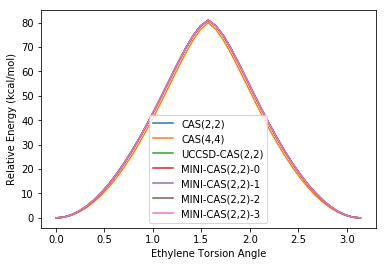

In [15]:
pylab.xlabel("Ethylene Torsion Angle")
pylab.ylabel("Relative Energy (kcal/mol)")
#pylab.plot(angles, hartree_to_kcal * (np.array(hf_energies) - hf_energies[0]), label="HF")
#pylab.plot(angles, hartree_to_kcal * (np.array(mp2_energies) - mp2_energies[0]), label="MP2")
#pylab.plot(angles, hartree_to_kcal * (np.array(cisd_energies) - cisd_energies[0]), label="CISD")
#pylab.plot(angles, hartree_to_kcal * (np.array(ccsd_energies) - ccsd_energies[0]), label="CCSD")
for key in ['CAS(2,2)', 'CAS(4,4)']: #cas_energies:                       
    pylab.plot(angles, 
               hartree_to_kcal * (np.array(cas_energies[key]) - cas_energies[key][0]),
              label=key)
for key in uccsd_energies:                       
    pylab.plot(angles, 
               hartree_to_kcal * (np.array(uccsd_energies[key]) - uccsd_energies[key][0]),
               label="UCCSD-" + key)
for key in mini_energies:                       
    pylab.plot(angles, 
               hartree_to_kcal * (np.array(mini_energies[key]) - mini_energies[key][0]),
               label="MINI-" + key)    
pylab.legend()
pylab.savefig("Ethylene_2_2_MINI_4Qubit.pdf")

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


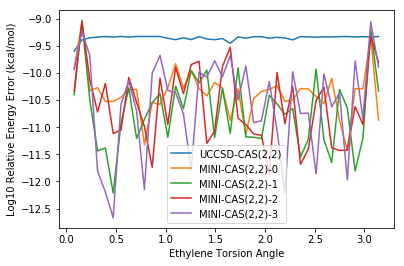

In [16]:
pylab.xlabel("Ethylene Torsion Angle")
pylab.ylabel("Log10 Relative Energy Error (kcal/mol)")
for key in uccsd_energies:                       
    pylab.plot(angles, 
               np.log10(np.abs((np.array(uccsd_energies[key]) - uccsd_energies[key][0]) - 
                                  (np.array(cas_energies["CAS(2,2)"]) - cas_energies["CAS(2,2)"][0]))),
               label="UCCSD-" + key)
for key in mini_energies:                       
    pylab.plot(angles, 
               np.log10(np.abs((np.array(mini_energies[key]) - mini_energies[key][0])- 
                                 (np.array(cas_energies["CAS(2,2)"]) - cas_energies["CAS(2,2)"][0]))),
               label="MINI-" + key)
pylab.legend()
pylab.savefig("Ethylene_MINI_Err_4Qubit.pdf")